<a href="https://colab.research.google.com/github/SommieB/Som-CC/blob/main/Etsy_Assignment_Somto_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# libraries
import io
import os
import glob
import random
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small,EfficientNetB0,EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#import tensorflow_addons as tfa
from sklearn import metrics

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

## Evaluation Metrics

In [ ]:
metric = tf.keras.metrics.F1Score(
    average=None, threshold=None, name='f1_score', dtype=None)

In [ ]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Loading of Etsy Dataset


In [ ]:
# set random seed
np.random.seed(seed=42)

In [ ]:
!ls /content/drive/MyDrive/etsy_data_2024

test  train


In [ ]:
# path to the directory containing the 'train' and 'test' folder
train_PATH = "/content/drive/MyDrive/etsy_data_2024/train"
test_PATH = "/content/drive/MyDrive/etsy_data_2024/test"

# glob to match all .parquet files in the directory
parquet_filenames_train = glob.glob(f"{train_PATH}/*.parquet")
parquet_filenames_test = glob.glob(f"{test_PATH}/*.parquet")

print(f"Number of files in train: {len(parquet_filenames_train)}")
print(f"Number of files in test: {len(parquet_filenames_test)}")

Number of files in train: 362
Number of files in test: 362


In [ ]:
## The image size are too high

# Set the random seed
random.seed(42)
# You can use any number as the seed

# using random
parquet_filenames_train = random.sample(parquet_filenames_train, 100)
#parquet_filenames_train = parquet_filenames_train[:50]

### Reading the Image File

In [ ]:
def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(filename)
        for filename in filenames
    ]

    return pd.concat(dataframes)

In [ ]:
## Training images
df_train = read_data("train", parquet_filenames_train)

In [ ]:
## Test images
df_test = read_data("test", parquet_filenames_test)

In [ ]:
f"Number of rows in train: {len(df_train):,}"

'Number of rows in train: 73,269'

In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 73,269'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"

'Number of columns in train: 26'

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [ ]:
df_train.head(2)

product_id                                              title  \
0  1550908415                              Psalms 34:10 | Magnet   
1   882678889  5 pair / 1000 Gauss Ceramic Ferrite Disc Magne...   

                                         description  \
0  A small little reminder in magnet form that th...   
1  1000 GAUSS CERAMIC FERRITE DISC MAGNET PAIR GO...   

                                                tags      type room  \
0  trinket,gift,encouragement,joy,Jesus,faith,scr...  physical        
1  ROUND,BIOMAGNETISMO,BIOMAGNETISM,THERAPEUTIC,D...  physical        

        craft_type recipient material occasion  ...  \
0  party & gifting                              ...   
1  party & gifting                              ...   

                                bottom_category_text top_category_id  \
0  craft_supplies_and_tools.glue_and_adhesives.ma...               6   
1  craft_supplies_and_tools.glue_and_adhesives.ma...               6   

          top_category_text primary_color_id primary_color_text  \
0  craft_supplies_and_tools                0              beige   
1  craft_supplies_and_tools                1              black   

   secondary_color_id secondary_color_text  \
0                  11                 pink   
1                  14                  red   

                                       image/encoded image/width  image/height  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570           738  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570           418  

[2 rows x 26 columns]

### Understanding the Target Features in the Training Data :                **Bottom_category_id**, **Top_category_id**, **Primary_color_id**, and **Secondary_color_id**

In [ ]:
df_train.columns

Index(['product_id', 'title', 'description', 'tags', 'type', 'room',
       'craft_type', 'recipient', 'material', 'occasion', 'holiday',
       'art_subject', 'style', 'shape', 'pattern', 'bottom_category_id',
       'bottom_category_text', 'top_category_id', 'top_category_text',
       'primary_color_id', 'primary_color_text', 'secondary_color_id',
       'secondary_color_text', 'image/encoded', 'image/width', 'image/height'],
      dtype='object')

In [ ]:
df_train['bottom_category_text'].value_counts()

art_and_collectibles.drawing_and_illustration.architectural_drawings                98
toys_and_games.sports_and_outdoor_games.martial_arts_and_boxing.boxing_gloves       98
craft_supplies_and_tools.closures_and_fasteners.buttons                             98
home_and_living.outdoor_and_garden.patio_furniture.patio_umbrellas                  97
home_and_living.outdoor_and_garden.plants.leaves_and_thorns                         97
                                                                                    ..
jewelry.earrings.kaan_chains                                                        45
electronics_and_accessories.parts_and_electrical.testing_and_calibration            45
home_and_living.furniture.entryway_furniture.standing_coat_racks                    44
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds    42
craft_supplies_and_tools.doll_and_model_supplies.noise_makers                       42
Name: bottom_category_text, Length: 833, dt

In [ ]:
target_features = ['bottom_category_id','top_category_id','primary_color_id','secondary_color_id']

In [ ]:
for col in target_features:
  print('-------------------------------------------')
  print(df_train[col].value_counts())
  print('-------------------------------------------')
  print(df_train[col].nunique())

-------------------------------------------
2070     98
2371     98
6270     98
1985     97
6883     97
         ..
12223    45
884      45
12405    44
2101     42
6796     42
Name: bottom_category_id, Length: 833, dtype: int64
-------------------------------------------
833
-------------------------------------------
8     17952
5     10000
6      9654
13     4410
0      4248
10     3954
3      3594
1      3243
14     3015
9      2716
4      2552
12     2338
7      2325
2      1990
11     1278
Name: top_category_id, dtype: int64
-------------------------------------------
15
-------------------------------------------
1     9919
17    9112
2     8757
4     6422
14    5151
11    4995
9     4936
0     3853
16    3554
7     3293
19    2796
18    2322
12    2145
10    1779
13    1469
5     1173
3      823
6      496
15     274
Name: primary_color_id, dtype: int64
-------------------------------------------
19
-------------------------------------------
17    11913
1      9381
2      5607


**We observed that the bottom_category_id have unique counts of more than 100, while the other three target features has unique counts of less than 20.**

### Reading the Training Images

In [ ]:
def show_images(dataframe,target, N=100):

    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows

    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row[target] if target in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

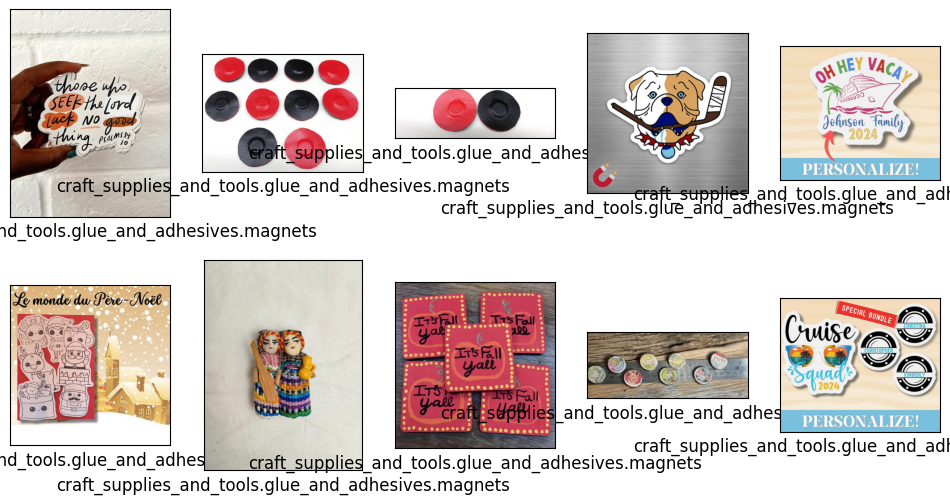

In [ ]:
show_images(df_train,'bottom_category_text', 10)

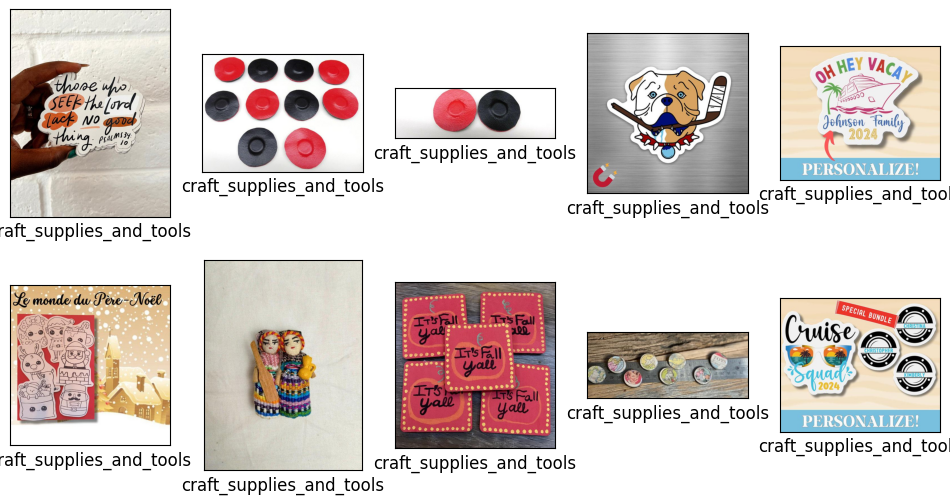

In [ ]:
show_images(df_train,'top_category_text', 10)

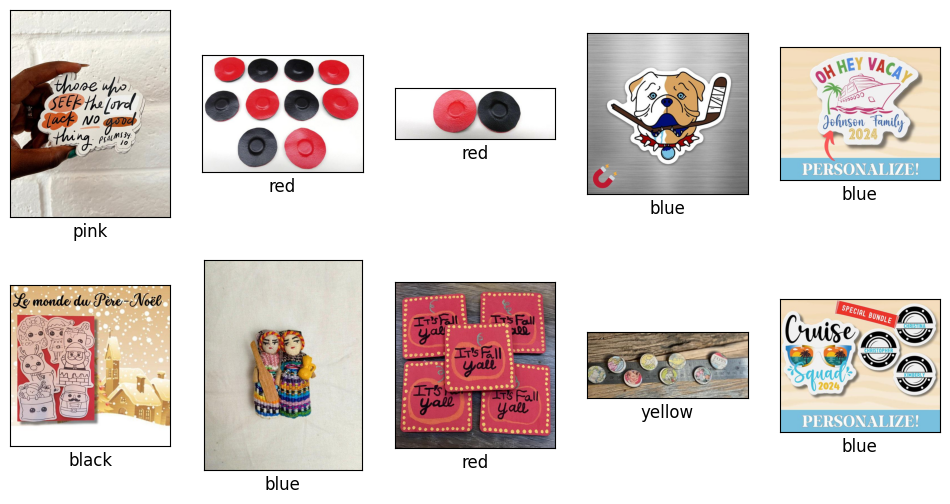

In [ ]:
show_images(df_train,'secondary_color_text', 12)

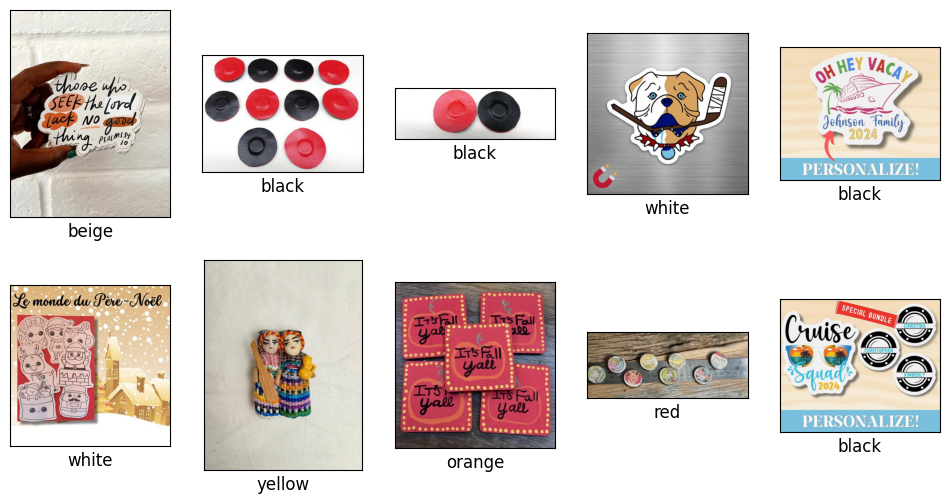

In [ ]:
show_images(df_train,'primary_color_text', 10)

### Reading the Testing Images

In [ ]:
df_test.head(2)

product_id                                              title  \
0   609243070         Indian Hand-block Printed Floral Bedspread   
1  1398220960  Vintage Cotton Bedspread | Woven Queen Coverle...   

                                         description  \
0  This beautiful red, yellow, blue and white flo...   
1  Vintage lightweight woven cotton coverlet from...   

                                                tags      type room  \
0  anokhi,bedspread,handcrafted,floral,tablecloth...  physical        
1  cotton throw blanket,lightweight coverlet,shab...  physical        

  craft_type recipient material occasion holiday art_subject style shape  \
0                        cotton                                            
1                adult   cotton                                            

  pattern                                      image/encoded  image/width  \
0  floral  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   
1  floral  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...          570   

   image/height  
0           420  
1          1095

In [ ]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 25,514'

In [ ]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 25,514'

In [ ]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

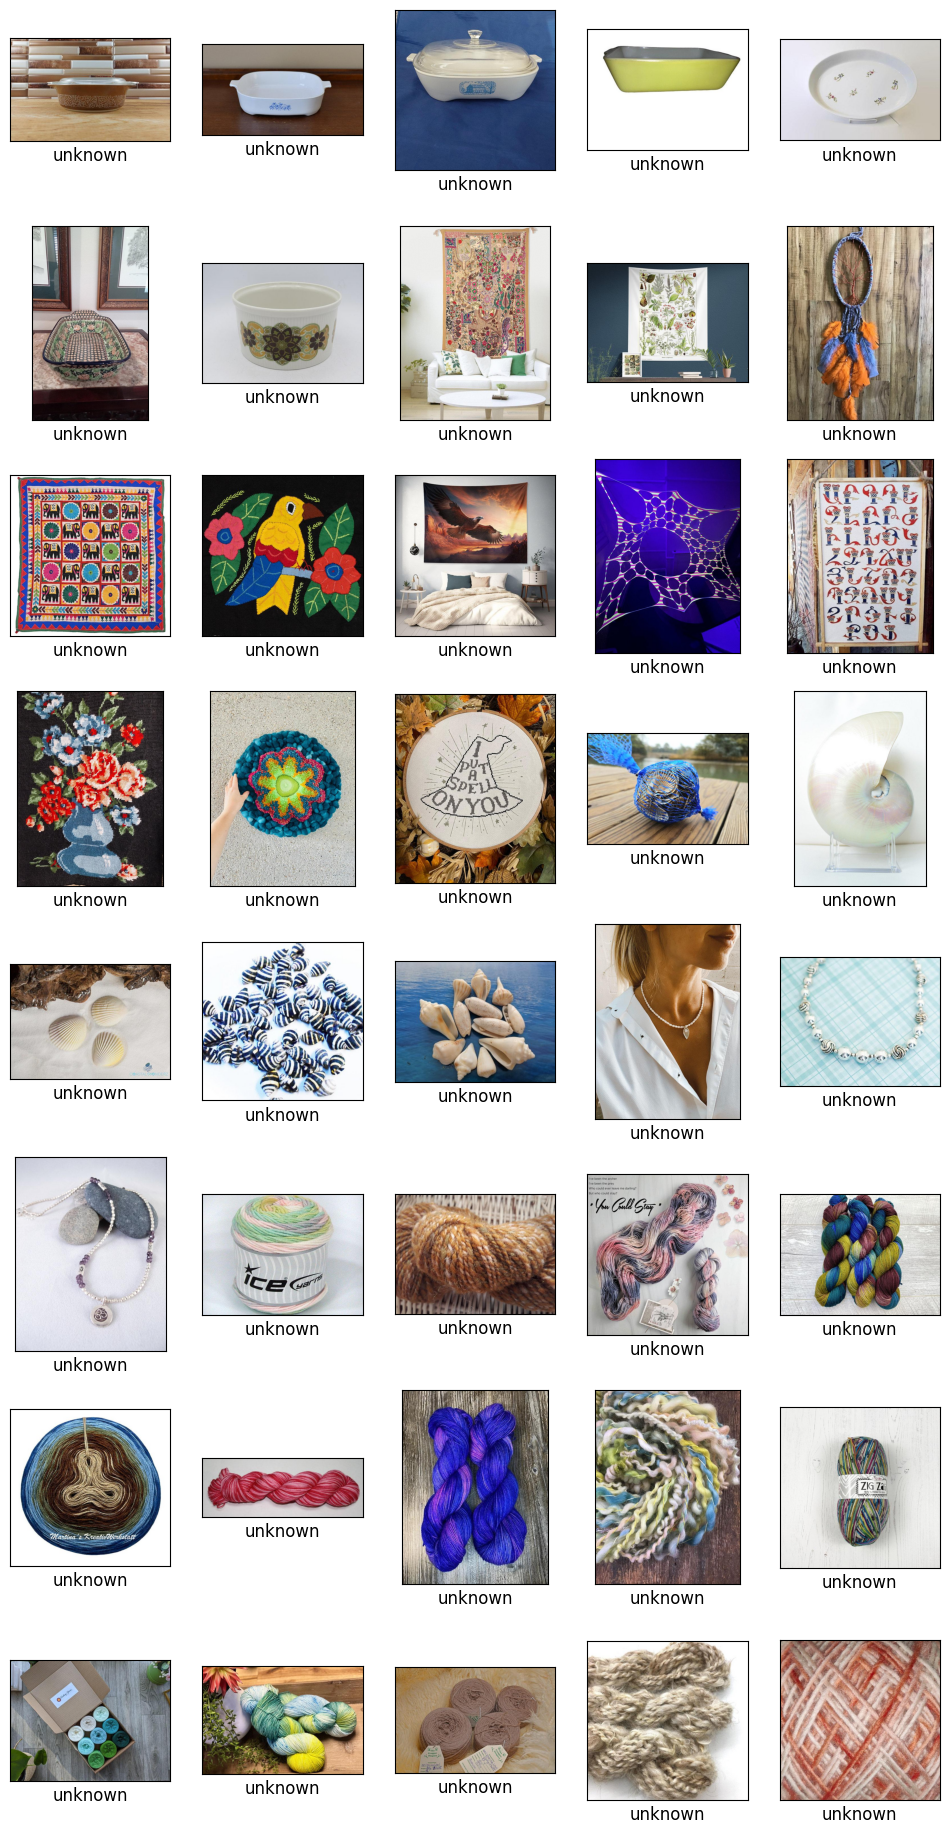

In [ ]:
show_images(df_test, 10)

### Image Preprocessing and Augmentation

### Training the model Pipeline

In [ ]:
NUM_CHANNELS = 3

def parse_dataset(features, target, num_classes):
    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]

    # Decode and preprocess the image
    image = tf.io.decode_jpeg(image_encoded)
    image = tf.reshape(image, [img_height, img_width, NUM_CHANNELS])
    image = tf.cast(image, tf.float32)
    image = tf.image.random_flip_left_right(image)  # Random flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = preprocess_input(image)  # Normalize image for efficient net

    # Labels
    labels = tf.one_hot(features[target], depth=num_classes)
    labels = tf.cast(labels, tf.int64)

    return {"image": image}, labels

In [ ]:
### we don't rescale
def create_preprocessing_model(target_image_size):
    preprocessing_layers = [
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    ]
    return tf.keras.Sequential(preprocessing_layers)

In [ ]:
def get_dataset_batch(
    dataframe,
    batch_size: int,
    mode: tf.estimator.ModeKeys,
    target: str,
    num_classes: int
) -> tf.data.Dataset:

    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN

    # Constructing the dataset from the dataframe
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image": tf.convert_to_tensor(dataframe["image/encoded"].values, dtype=tf.string),
                "height": tf.convert_to_tensor(dataframe["image/height"].values, dtype=tf.int32),
                "width": tf.convert_to_tensor(dataframe["image/width"].values, dtype=tf.int32),
                target: tf.convert_to_tensor(dataframe[target].values, dtype=tf.int32),
            }
        )
    )

    # Parsing dataset with the updated parse_dataset function
    dataset = dataset.map(
        lambda features: parse_dataset(features, target, num_classes),
        #lambda x: parse_dataset(x, target),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )

    # Apply preprocessing (resizing only, no rescaling as per new requirements)
    preprocessing_model = create_preprocessing_model(target_image_size=224)
    dataset = dataset.map(
        lambda x, y: ({"image": preprocessing_model(x["image"])}, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )


    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
BATCH_SIZE = 16

## Primary Color

### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
target = 'primary_color_id'
df_training, df_validation = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train[target], ## For maintaining class balance in training and validation data
    random_state=42)

### Loading the data

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
    target = target,
    num_classes = 19)

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
     target = target,
    num_classes = 19
)

In [ ]:
for images, labels in train_dataset.take(1):
    # `images` contains a batch of images
    # `labels` contains the corresponding labels for the batch
    break

In [ ]:
#labels

In [ ]:
len(labels)

16

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()

### Model Architecture

Using an advanced architecture for image classification to predict color based on the image class, We utilized EfficientNetB1 as the backbone model, initializing it with weights pre-trained on ImageNet and freezing its layers.

In [ ]:
NUM_LABELS = 19

with strategy.scope():
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)  # Change for multi-label

    model_primary = Model(inputs=inputs, outputs=predictions)

    # Compile model for multi-label with binary crossentropy and possibly including F1 score as a metric
    model_primary.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])  # Consider custom metrics as needed


27018416/27018416 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#model_primary.summary()

In [ ]:
epochs = 5

hist = model_primary.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/5
3663/3663 [==============================] - 343s 79ms/step - loss: 0.1468 - accuracy: 0.3849 - f1_metric: 0.3180 - val_loss: 0.1396 - val_accuracy: 0.4231 - val_f1_metric: 0.3499
Epoch 2/5
3663/3663 [==============================] - 287s 78ms/step - loss: 0.1365 - accuracy: 0.4226 - f1_metric: 0.3785 - val_loss: 0.1361 - val_accuracy: 0.4333 - val_f1_metric: 0.3791
Epoch 3/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.1314 - accuracy: 0.4496 - f1_metric: 0.4139 - val_loss: 0.1401 - val_accuracy: 0.4175 - val_f1_metric: 0.3787
Epoch 4/5
3663/3663 [==============================] - 287s 78ms/step - loss: 0.1267 - accuracy: 0.4714 - f1_metric: 0.4463 - val_loss: 0.1382 - val_accuracy: 0.4273 - val_f1_metric: 0.3891
Epoch 5/5
3663/3663 [==============================] - 289s 79ms/step - loss: 0.1218 - accuracy: 0.4949 - f1_metric: 0.4781 - val_loss: 0.1386 - val_accuracy: 0.4303 - val_f1_metric: 0.4038


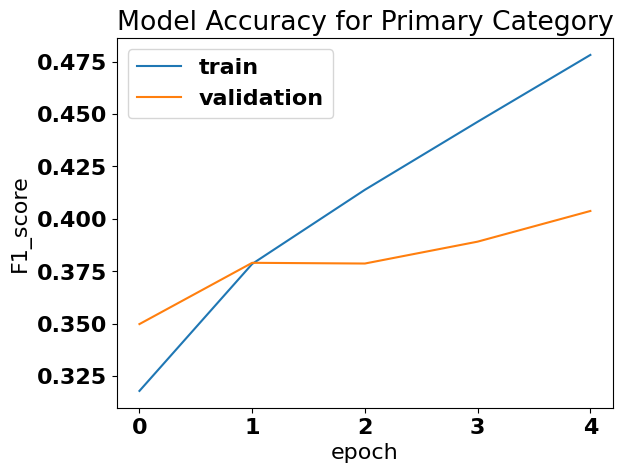

In [ ]:
plt.plot(hist.history["f1_metric"])
plt.plot(hist.history["val_f1_metric"])
plt.title("Model Accuracy for Primary Category")
plt.ylabel("F1_score")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

##  Secondary_color_id

In [ ]:
from sklearn.model_selection import train_test_split
target = 'secondary_color_id'
df_training, df_validation = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train[target], ## For maintaining class balance in training and validation data
    random_state=42)

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
    target = target,
    num_classes = 19)

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
     target = target,
    num_classes = 19
)

In [ ]:
NUM_LABELS = 19

with strategy.scope():
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)  # Change for multi-label

    model_secondary = Model(inputs=inputs, outputs=predictions)

    # Compile model for multi-label with binary crossentropy and possibly including F1 score as a metric
    model_secondary.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])  # Consider custom metrics as needed


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
epochs = 5

hist1 = model_secondary.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/5
3663/3663 [==============================] - 333s 78ms/step - loss: 0.1706 - accuracy: 0.2211 - f1_metric: 0.0498 - val_loss: 0.1630 - val_accuracy: 0.2501 - val_f1_metric: 0.0993
Epoch 2/5
3663/3663 [==============================] - 285s 78ms/step - loss: 0.1632 - accuracy: 0.2542 - f1_metric: 0.0774 - val_loss: 0.1631 - val_accuracy: 0.2528 - val_f1_metric: 0.1221
Epoch 3/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.1598 - accuracy: 0.2706 - f1_metric: 0.1048 - val_loss: 0.1618 - val_accuracy: 0.2643 - val_f1_metric: 0.1448
Epoch 4/5
3663/3663 [==============================] - 285s 78ms/step - loss: 0.1566 - accuracy: 0.2889 - f1_metric: 0.1340 - val_loss: 0.1641 - val_accuracy: 0.2600 - val_f1_metric: 0.1795
Epoch 5/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.1533 - accuracy: 0.3079 - f1_metric: 0.1679 - val_loss: 0.1663 - val_accuracy: 0.2627 - val_f1_metric: 0.1867


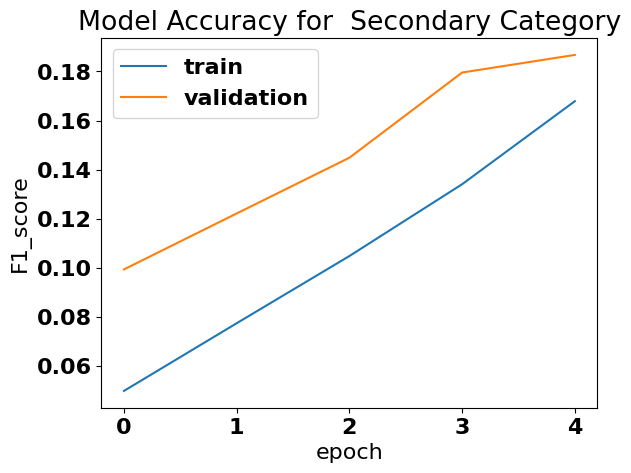

In [ ]:
plt.plot(hist1.history["f1_metric"])
plt.plot(hist1.history["val_f1_metric"])
plt.title("Model Accuracy for  Secondary Category")
plt.ylabel("F1_score")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### Top_category_id

In [ ]:
from sklearn.model_selection import train_test_split
target = 'top_category_id'
df_training, df_validation = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train[target], ## For maintaining class balance in training and validation data
    random_state=42)

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
    target = target,
    num_classes = 15)

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
     target = target,
    num_classes = 15
)

In [ ]:
NUM_LABELS = 15

with strategy.scope():
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)  # Change for multi-label

    model_top = Model(inputs=inputs, outputs=predictions)

    # Compile model for multi-label with binary crossentropy and possibly including F1 score as a metric
    model_top.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])  # Consider custom metrics as needed


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
epochs = 5

hist2 = model_top.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/5
3663/3663 [==============================] - 335s 79ms/step - loss: 0.1819 - accuracy: 0.4259 - f1_metric: 0.3571 - val_loss: 0.1734 - val_accuracy: 0.4708 - val_f1_metric: 0.4547
Epoch 2/5
3663/3663 [==============================] - 287s 78ms/step - loss: 0.1653 - accuracy: 0.4778 - f1_metric: 0.4358 - val_loss: 0.1692 - val_accuracy: 0.4803 - val_f1_metric: 0.4693
Epoch 3/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.1542 - accuracy: 0.5149 - f1_metric: 0.4908 - val_loss: 0.1664 - val_accuracy: 0.5034 - val_f1_metric: 0.4975
Epoch 4/5
3663/3663 [==============================] - 287s 78ms/step - loss: 0.1437 - accuracy: 0.5494 - f1_metric: 0.5326 - val_loss: 0.1651 - val_accuracy: 0.5134 - val_f1_metric: 0.5074
Epoch 5/5
3663/3663 [==============================] - 287s 78ms/step - loss: 0.1336 - accuracy: 0.5858 - f1_metric: 0.5742 - val_loss: 0.1691 - val_accuracy: 0.5202 - val_f1_metric: 0.5185


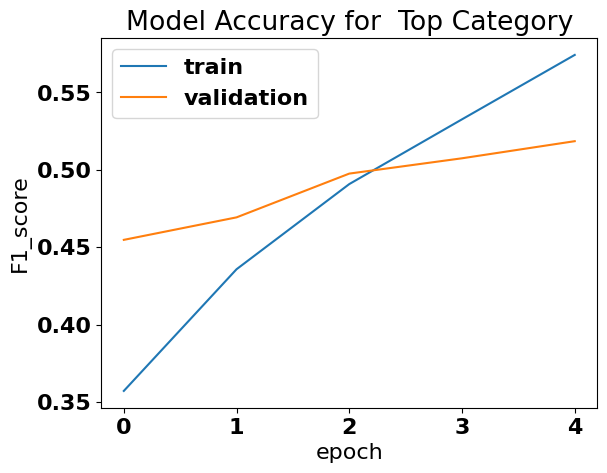

In [ ]:
plt.plot(hist2.history["f1_metric"])
plt.plot(hist2.history["val_f1_metric"])
plt.title("Model Accuracy for  Top Category")
plt.ylabel("F1_score")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

## Bottom_category_id

In [ ]:
from sklearn.model_selection import train_test_split
target = 'bottom_category_id'
class_num = df_train[target].nunique()
df_training, df_validation = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train[target], ## For maintaining class balance in training and validation data
    random_state=42)

In [ ]:
train_dataset = get_dataset_batch(
    dataframe=df_training,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
    target = target,
    num_classes = class_num)

In [ ]:
val_dataset = get_dataset_batch(
    dataframe=df_validation,
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
     target = target,
    num_classes = class_num
)

In [ ]:
NUM_LABELS = class_num

with strategy.scope():
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)  # Change for multi-label

    model_bottom = Model(inputs=inputs, outputs=predictions)

    # Compile model for multi-label with binary crossentropy and possibly including F1 score as a metric
    model_bottom.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])  # Consider custom metrics as needed


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
epochs = 5

hist3 = model_bottom.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/5
3663/3663 [==============================] - 334s 78ms/step - loss: 0.0027 - accuracy: 0.0259 - f1_metric: 0.0488 - val_loss: 0.0016 - val_accuracy: 0.0471 - val_f1_metric: 0.1111
Epoch 2/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.0015 - accuracy: 0.0448 - f1_metric: 0.1035 - val_loss: 0.0016 - val_accuracy: 0.0458 - val_f1_metric: 0.1164
Epoch 3/5
3663/3663 [==============================] - 285s 78ms/step - loss: 0.0015 - accuracy: 0.0531 - f1_metric: 0.1259 - val_loss: 0.0016 - val_accuracy: 0.0530 - val_f1_metric: 0.1401
Epoch 4/5
3663/3663 [==============================] - 285s 78ms/step - loss: 0.0013 - accuracy: 0.0659 - f1_metric: 0.1675 - val_loss: 0.0016 - val_accuracy: 0.0588 - val_f1_metric: 0.1514
Epoch 5/5
3663/3663 [==============================] - 286s 78ms/step - loss: 0.0012 - accuracy: 0.0807 - f1_metric: 0.2120 - val_loss: 0.0018 - val_accuracy: 0.0586 - val_f1_metric: 0.1391


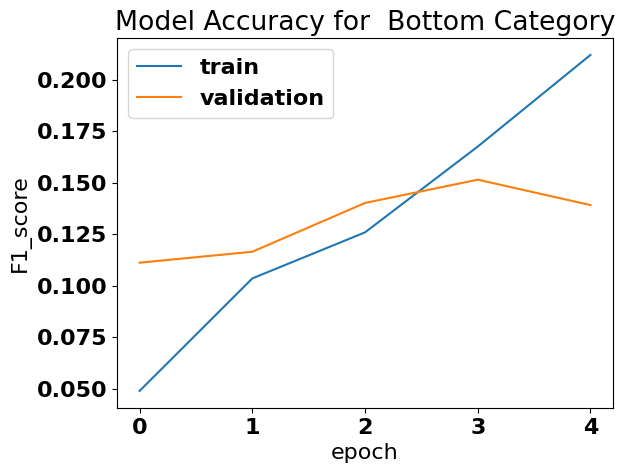

In [ ]:
plt.plot(hist3.history["f1_metric"])
plt.plot(hist3.history["val_f1_metric"])
plt.title("Model Accuracy for  Bottom Category")
plt.ylabel("F1_score")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

## Prediction of Test_set Data

In [ ]:
NUM_CHANNELS = 3
def parse_dataset_test(features):
    # Features
    image_encoded = features["image"]
    img_width = features["width"]
    img_height = features["height"]

    # Decode and preprocess the image
    image = tf.io.decode_jpeg(image_encoded)
    image = tf.reshape(image, [img_height, img_width, NUM_CHANNELS])
    image = tf.cast(image, tf.float32)

    return {"image": image}


In [ ]:
def get_dataset_batch_test(
    dataframe,
    batch_size: int,
) -> tf.data.Dataset:

    # Constructing the dataset from the dataframe
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "image": tf.convert_to_tensor(dataframe["image/encoded"].values, dtype=tf.string),
                "height": tf.convert_to_tensor(dataframe["image/height"].values, dtype=tf.int32),
                "width": tf.convert_to_tensor(dataframe["image/width"].values, dtype=tf.int32)
            }
        )
    )

    # Parsing dataset with the updated parse_dataset function
    test_dataset = test_dataset.map(
        lambda x: parse_dataset_test(x),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )

    # Apply preprocessing (resizing only, no rescaling as per new requirements)
    preprocessing_model = create_preprocessing_model(target_image_size=224)
    test_dataset = test_dataset.map(
        lambda x: {"image": preprocessing_model(x["image"])},
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )


    test_dataset = test_dataset.batch(batch_size, drop_remainder=False) ## we need all the images in the test set
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return test_dataset


In [ ]:
test_dataset = get_dataset_batch_test(
    dataframe=df_test,
    batch_size=BATCH_SIZE
)

In [ ]:
len(test_dataset)

1595

In [ ]:
predictions_primary = model_primary.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions_secondary = model_secondary.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions_top = model_top.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions_bottom = model_bottom.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
predictions_primary = model_primary.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)
predictions_secondary = model_secondary.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)
predictions_top = model_top.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)
predictions_bottom = model_bottom.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

1595/1595 [==============================] - 27s 15ms/step


In [ ]:
pred_primary = pd.DataFrame(predictions_primary.argmax(-1))
pred_secondary = pd.DataFrame(predictions_secondary.argmax(-1))
pred_top = pd.DataFrame(predictions_top.argmax(-1))
pred_bottom = pd.DataFrame(predictions_bottom.argmax(-1))

In [ ]:
df_test['primary_color_id'] = predictions_primary.argmax(-1)
df_test['secondary_color_id'] = predictions_secondary.argmax(-1)
df_test['top_category_id'] = predictions_top.argmax(-1)
df_test['bottom_category_id'] = predictions_bottom.argmax(-1)

In [ ]:
df_test.head()

product_id                                              title  \
0   609243070         Indian Hand-block Printed Floral Bedspread   
1  1398220960  Vintage Cotton Bedspread | Woven Queen Coverle...   
2  1436000310  Silk Embroidery Suzani,Cotton Fabric,Suzani Be...   
3   719170010  Floral Printed Indian Handmade Pure Cotton Bed...   
4  1242444210  Bates 1940s-50s Floral Bedspread, White with p...   

                                         description  \
0  This beautiful red, yellow, blue and white flo...   
1  Vintage lightweight woven cotton coverlet from...   
2  Silk Embroidery Suzani,Cotton Fabric,Suzani Be...   
3  Welcome\n\nProduct Description\n\nThis Paisley...   
4  This lovely Bates has its tag, with Made in th...   

                                                tags      type room  \
0  anokhi,bedspread,handcrafted,floral,tablecloth...  physical        
1  cotton throw blanket,lightweight coverlet,shab...  physical        
2  suzani,old textile,suzani rug,tribal table cov...  physical        
3  Handmade Kantha,Kantha Quilt,Kantha Bedspread,...  physical        
4  Bates bedspread,Made in USA spread,1940s Bates...  physical        

  craft_type recipient material occasion  ... style shape pattern  \
0                        cotton           ...              floral   
1                adult   cotton           ...              floral   
2                 kids     silk           ...              floral   
3                adult    linen           ...              floral   
4                adult   cotton           ...              floral   

                                       image/encoded image/width image/height  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570          420   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570         1095   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570          381   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570          400   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...         570          583   

   primary_color_id  secondary_color_id  top_category_id  bottom_category_id  
0                14                   2                1                 106  
1                14                  11                6                  93  
2                17                  18                8                 106  
3                14                  11                8                  93  
4                 4                  11                6                 403  

[5 rows x 22 columns]

In [ ]:
df_test.to_csv('assignment_with_prediction.csv', index=False)

### Prediction

In [ ]:
#student_id = "23267439"
df_test.to_parquet('output_file_23267439.parquet')

In [ ]:
df_test.columns

Index(['product_id', 'title', 'description', 'tags', 'type', 'room',
       'craft_type', 'recipient', 'material', 'occasion', 'holiday',
       'art_subject', 'style', 'shape', 'pattern', 'image/encoded',
       'image/width', 'image/height', 'primary_color_id', 'secondary_color_id',
       'top_category_id', 'bottom_category_id'],
      dtype='object')

In [ ]:
predictions = df_test[['primary_color_id', 'secondary_color_id','top_category_id', 'bottom_category_id']]

In [ ]:
predictions.to_parquet('student_file_23267439.parquet')